# Analyzing the effect of income and area of residence on quality of education

### Introduction
The Scholastic Aptitude Test (SAT) is a standardized test taken by most high school students across the United States (and some international students), often used for post-secondary admissions. The question we will try to answer with the project is: What SAT score is a NYC student likely to get as a result of their income and their school’s location? A dataset listing the average SAT scores per school in New York will be used; this dataset also lists the zip codes of each school. The average SAT scores of all schools in each zip code will then be compared with data from an income per zip code database.

### Methods
We will use linear regression to predict SAT scores given household income. From the average SAT scores dataset, we will be using Average SAT Scores (math, reading, writing), and student enrollment. From the average income data, we will be using Zip.Code, total_pop, total_income, and avg_income. We will visualize the results with a scatterplot (average SAT scores per zip code vs. average income per zip code)

### Expectations
We expect higher income ZIP codes will have higher average SAT scores, assuming that those who live in a higher income area will receive better education. If data suggests so, actions could be taken to minimize the effect of someone's place of residence on their education. An example of a future question this could lead to is: Are there other environmental factors affecting average SAT scores for specific areas?


## Preliminary exploratory data analysis

### Run before

In [3]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

### Download files

In [4]:
sat_scores <- read_csv("https://raw.githubusercontent.com/emi31770/proposal/main/datesets/sat_scores.csv")
zip_income <- read_csv("https://raw.githubusercontent.com/emi31770/proposal/main/datesets/zipcodes_income.csv")
colnames(sat_scores) <- make.names(colnames(sat_scores))
colnames(zip_income) = make.names(colnames(zip_income))
write_csv(sat_scores, "sat.csv")
write_csv(zip_income, "zip.csv")

Parsed with column specification:
cols(
  .default = col_character(),
  `Zip Code` = col_double(),
  Latitude = col_double(),
  Longitude = col_double(),
  `Start Time` = col_time(format = ""),
  `End Time` = col_time(format = ""),
  `Student Enrollment` = col_double(),
  `Average Score (SAT Math)` = col_double(),
  `Average Score (SAT Reading)` = col_double(),
  `Average Score (SAT Writing)` = col_double()
)

See spec(...) for full column specifications.

Parsed with column specification:
cols(
  state = col_character(),
  zipcode = col_double(),
  total_pop = col_double(),
  total_income = col_double(),
  country = col_character(),
  avg_income = col_double()
)



In [5]:
zip_income <- read_csv("zip.csv")
sat_scores <- read_csv("sat.csv")

zip_income <- zip_income %>% 
                filter(state == "NY", country == "USA") %>% 
                mutate(Zip.Code = zipcode) %>% 
                select(Zip.Code, total_pop, total_income, avg_income)

sat_scores <- sat_scores %>% 
                mutate(total_score_avg = Average.Score..SAT.Math. + Average.Score..SAT.Reading. + Average.Score..SAT.Writing.) %>%
                select(Zip.Code, Student.Enrollment, total_score_avg, Average.Score..SAT.Math., Average.Score..SAT.Reading., Average.Score..SAT.Writing.) %>%
                na.omit() %>%
                group_by(Zip.Code) %>%
                summarize_all("mean")


joined_tables <- merge(x = sat_scores,y = zip_income, by = "Zip.Code")


head(joined_tables, 5)

Parsed with column specification:
cols(
  state = col_character(),
  zipcode = col_double(),
  total_pop = col_double(),
  total_income = col_double(),
  country = col_character(),
  avg_income = col_double()
)

Parsed with column specification:
cols(
  .default = col_character(),
  Zip.Code = col_double(),
  Latitude = col_double(),
  Longitude = col_double(),
  Start.Time = col_time(format = ""),
  End.Time = col_time(format = ""),
  Student.Enrollment = col_double(),
  Average.Score..SAT.Math. = col_double(),
  Average.Score..SAT.Reading. = col_double(),
  Average.Score..SAT.Writing. = col_double()
)

See spec(...) for full column specifications.



,Zip.Code,Student.Enrollment,total_score_avg,Average.Score..SAT.Math.,Average.Score..SAT.Reading.,Average.Score..SAT.Writing.,total_pop,total_income,avg_income
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,10002,504.7273,1358.909,472.9091,448.5455,437.4545,42400,2718913,64125.31
2,10003,693.2000,1323.600,449.6000,443.4000,430.6000,29270,8191737,279868.02
3,10004,519.2500,1380.250,463.0000,462.0000,455.2500,2470,944925,382560.73
4,10006,747.5000,1268.000,429.5000,419.0000,419.5000,2510,577145,229938.25
5,10009,666.0000,1327.000,454.0000,428.0000,445.0000,33200,2948597,88813.16


In [6]:
set.seed(1234)

sat_split <- initial_split(joined_tables, prop = 0.75, strata = total_score_avg)
sat_training <- training(sat_split)
sat_testing <- testing(sat_split)

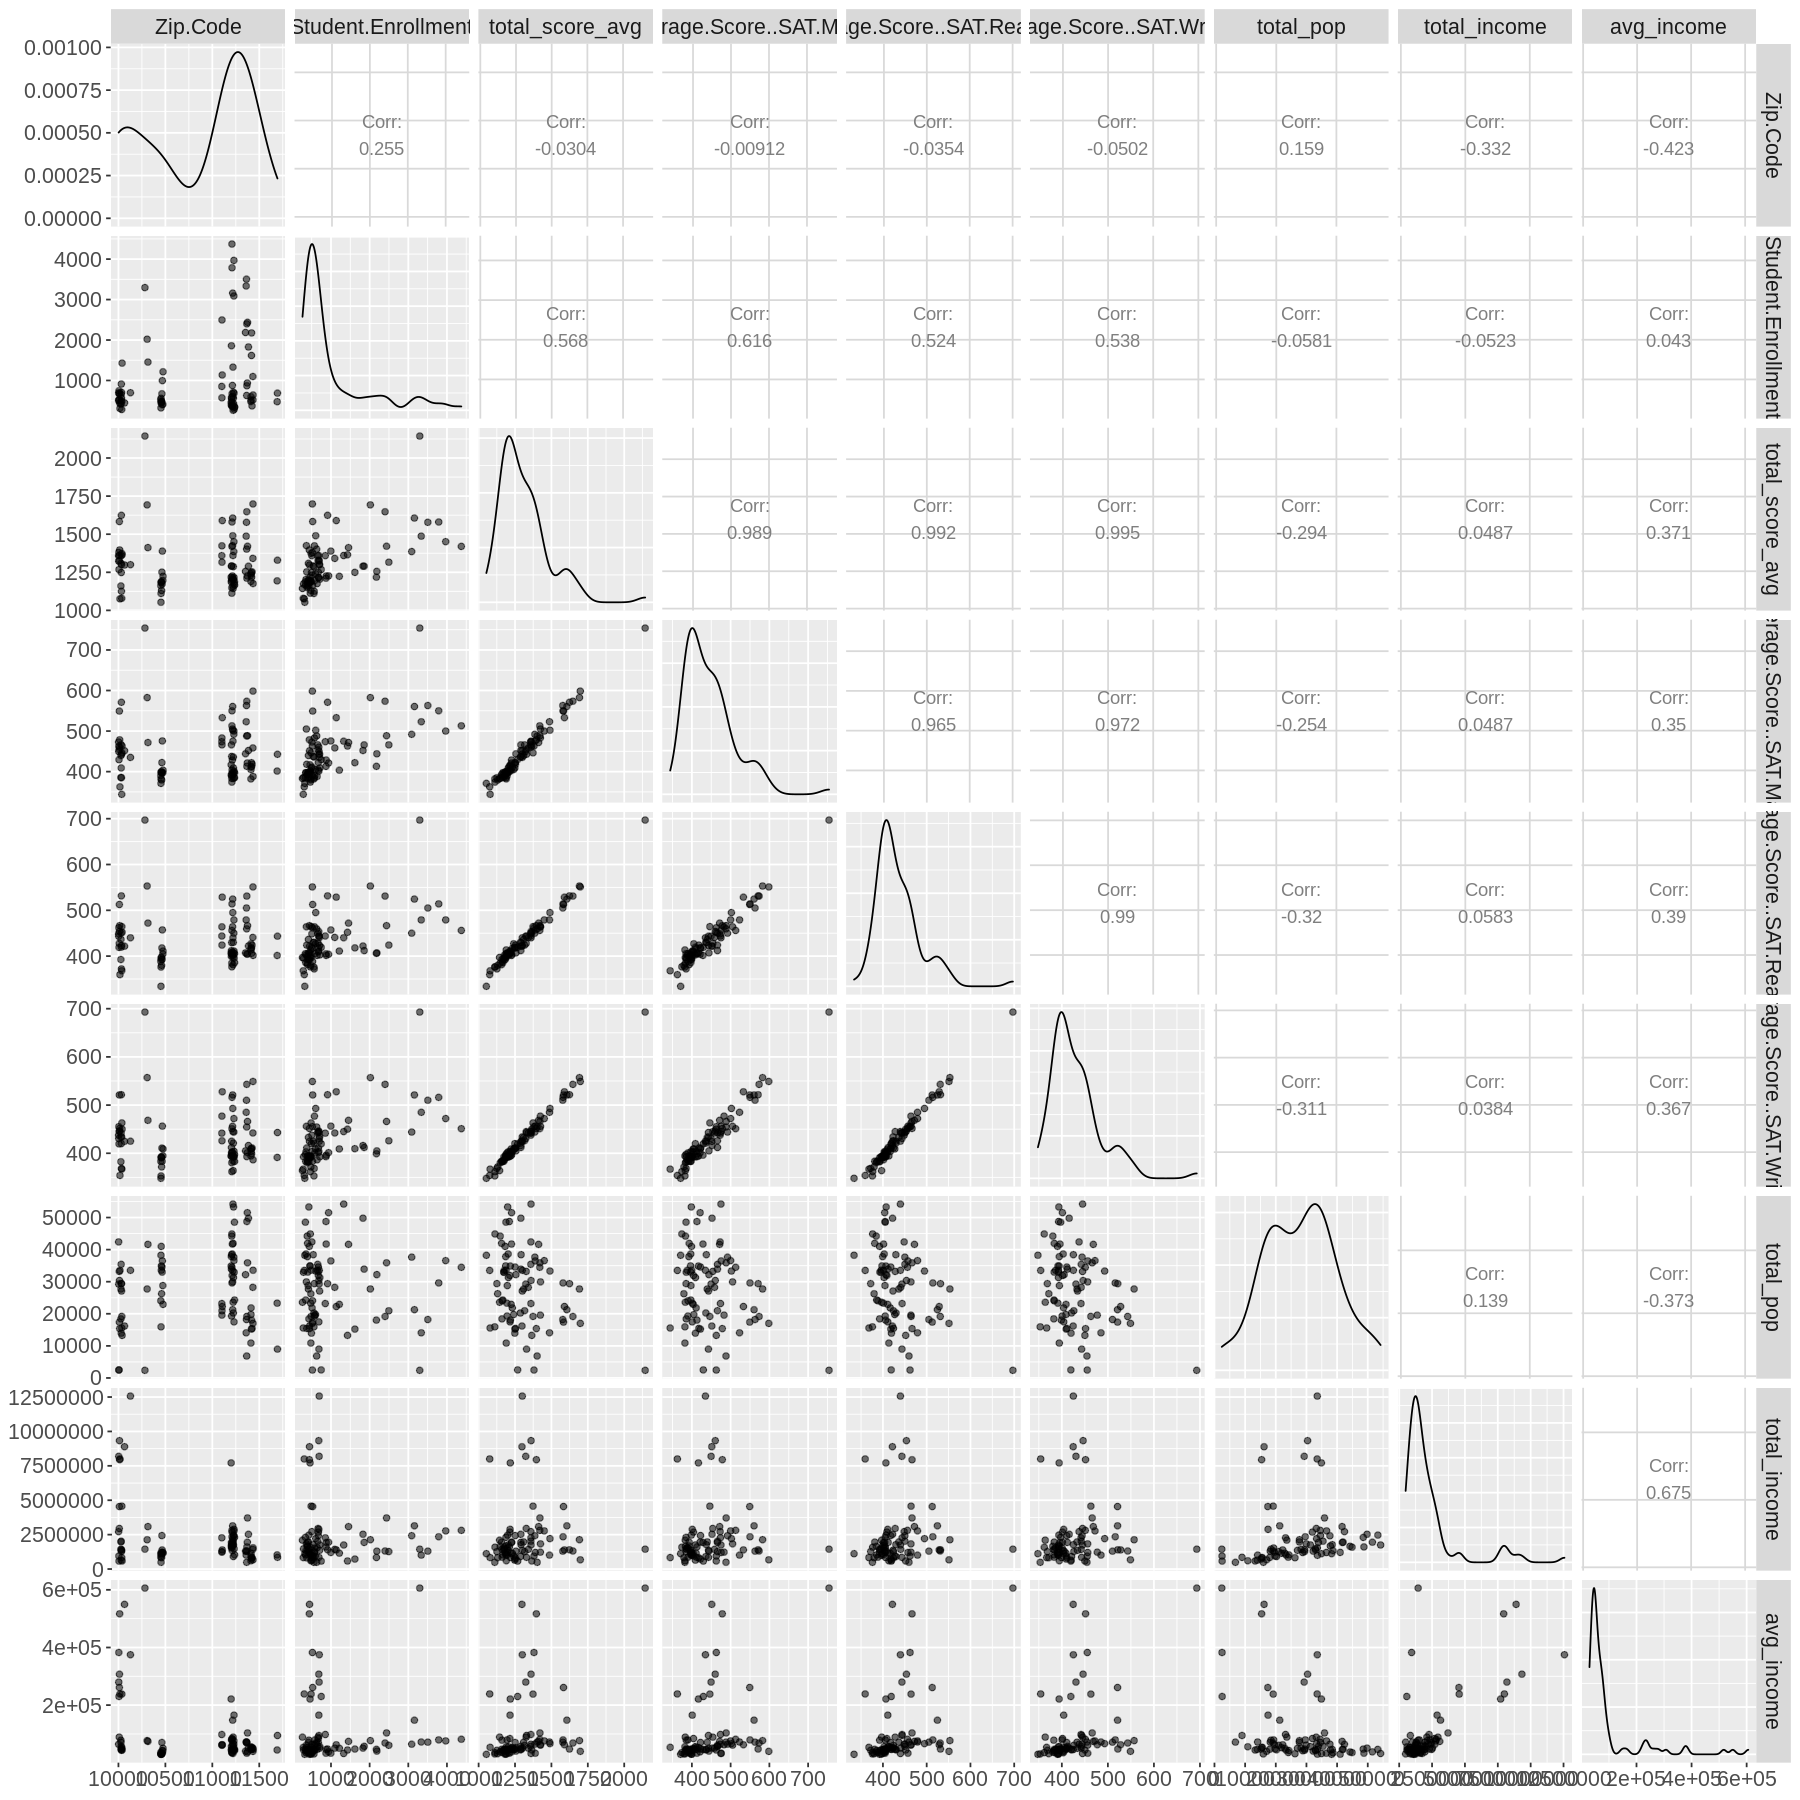

In [7]:
options(repr.plot.width = 15, repr.plot.height = 15)

sat_eda <- sat_training %>%
                ggpairs(mapping = aes(alpha = 0.4)) +
                theme(text = element_text(size = 16))

sat_eda

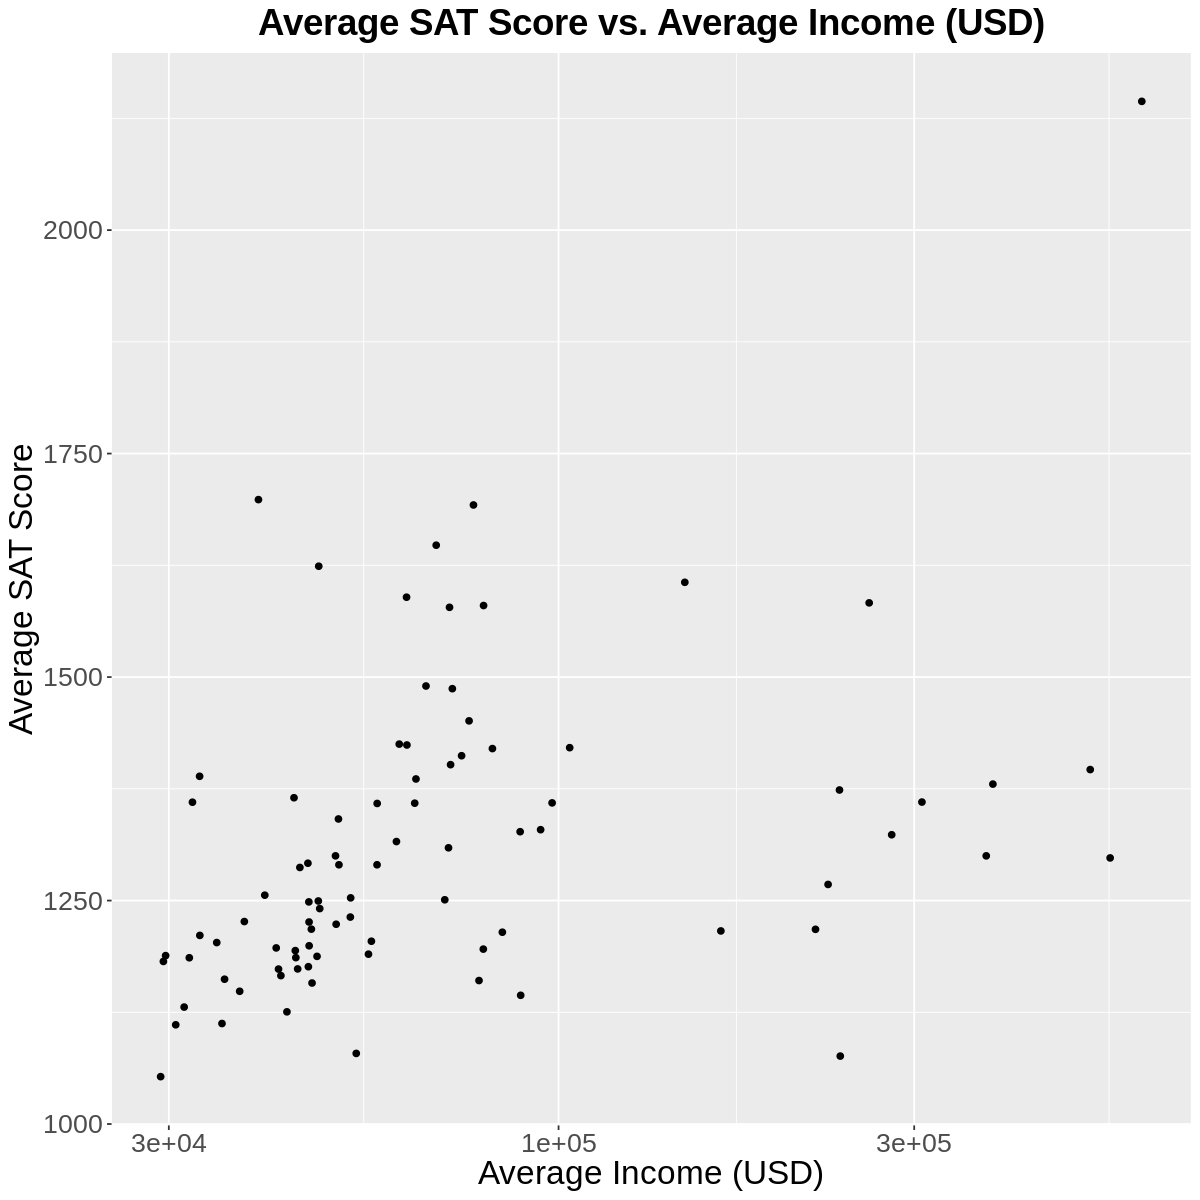

In [8]:
options(repr.plot.width = 10, repr.plot.height = 10)

scores_income <- ggplot(sat_training, aes(x = avg_income, y = total_score_avg)) +
                    geom_point() +
                    xlab("Average Income (USD)") +
                    scale_x_log10() +
                    ylab("Average SAT Score") +
                    theme(text = element_text(size = 20)) +
                    ggtitle("Average SAT Score vs. Average Income (USD)") +
                    theme(plot.title = element_text(size = 22)) +
                    theme(plot.title = element_text(face = "bold")) +
                    theme(plot.title = element_text(hjust = 0.5)) 

scores_income

In [11]:
sat_vfold <- vfold_cv(sat_training, v=5, strata=total_score_avg)

k_vals <- tibble(neighbors = seq(from = 1, to=20))

knn_spec = nearest_neighbor(weight_func="rectangular", neighbors=tune()) %>%
                set_engine("kknn") %>%
                set_mode("regression")

sat_recipe = recipe(total_score_avg ~ avg_income, data=sat_training) %>%
                step_scale(all_predictors()) %>% 
                step_center(all_predictors())

sat_workflow = workflow() %>%
                add_recipe(sat_recipe) %>%
                add_model(knn_spec)

sat_results = sat_workflow %>%
                tune_grid(resamples = sat_vfold, grid = k_vals) %>%
                collect_metrics() %>%
                filter(.metric == "rmse")

sat_results

k_min = sat_results %>% filter(mean == min(mean))

k_min
            

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,198.0331,5,25.56748,Model01
2,rmse,standard,185.7228,5,19.29734,Model02
3,rmse,standard,168.2118,5,22.21008,Model03
4,rmse,standard,164.2042,5,25.34981,Model04
5,rmse,standard,159.5897,5,25.83212,Model05
6,rmse,standard,158.1139,5,26.19803,Model06
7,rmse,standard,154.0154,5,26.48522,Model07
8,rmse,standard,155.8206,5,28.27700,Model08
9,rmse,standard,155.4967,5,27.82876,Model09


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
17,rmse,standard,149.8948,5,27.6982,Model17
